# under construction


In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as ppt
%load_ext autoreload
%autoreload 2

In [2]:
# import IPython
# print(IPython.sys_info())

In [3]:
# Spatial domain steerability

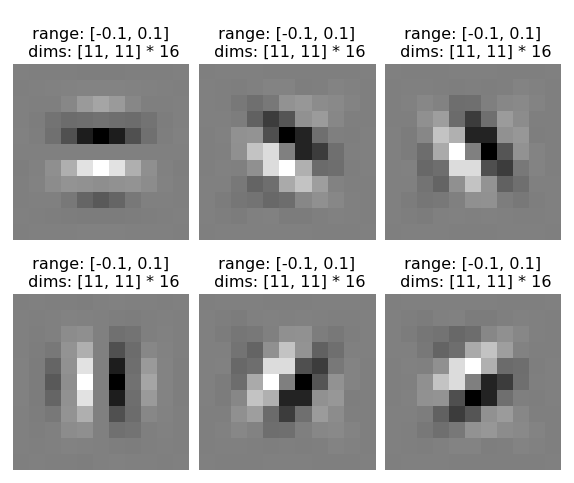

In [4]:
# Choose a filter set (options are 'sp0Filters', 'sp1Filters', 'sp3Filters', 'sp5Filters'):
filters = ppt.steerable_filters('sp5Filters')
fsz = int(np.round(np.sqrt(filters['bfilts'].shape[0])))

fsz = np.array([fsz, fsz])
nfilts = filters['bfilts'].shape[1]
nrows = int(np.floor(np.sqrt(nfilts)))

import scipy.signal as sps
# Look at the oriented bandpass filters:
filtList = []
for f in range(nfilts):
    filtList.append(sps.convolve2d(filters['bfilts'][:,f].reshape(fsz), filters['lo0filt']))

ppt.imshow(filtList, zoom= 16, col_wrap= 3);

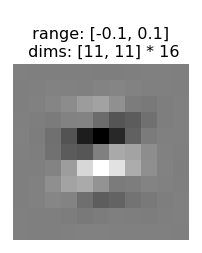

In [5]:
# Try "steering" to a new orientation (new_ori in degrees):
new_ori = -12

ppt.imshow( sps.convolve2d( ppt.steer(filters['bfilts'],
                                      new_ori * np.pi/180).reshape(fsz),
                           filters['lo0filt']), 'auto', 16);

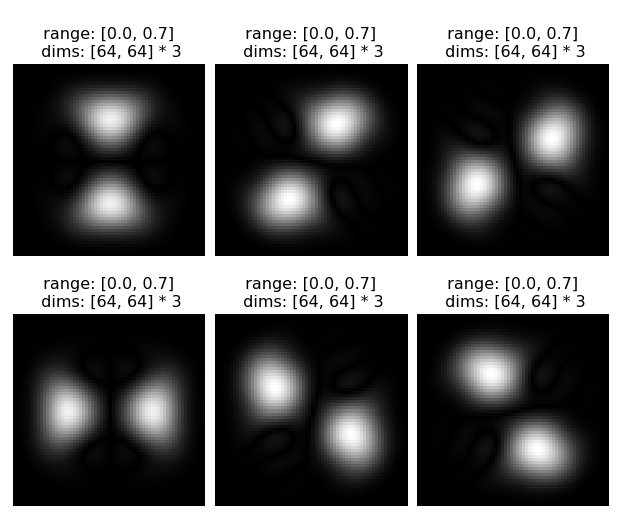

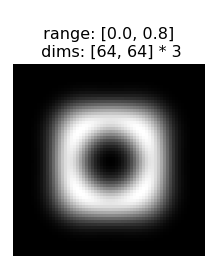

In [6]:
# Look at Fourier transform magnitudes:
lo0filt = filters['lo0filt']
bfilts = filters['bfilts']
lo0 = np.fft.fftshift(np.abs(np.fft.fft2(filters['lo0filt'],(64,64))))
fsum = np.zeros(lo0.shape)
imgList = []
for f in range(bfilts.shape[1]):
    flt = bfilts[:,f].reshape(fsz)
    freq = lo0 * np.fft.fftshift(np.abs(np.fft.fft2(flt,(64,64))))
    fsum += freq**2
    imgList.append(freq)

ppt.imshow(imgList, vrange='auto', zoom=3, col_wrap= 3)

# The filters sum to a smooth annular ring:
ppt.imshow(fsum, 'auto', 3);

In [7]:
# Looking again at the frequency domain picture

In [8]:
sz = 256
pyr = ppt.SFpyr(np.zeros((sz,sz)))

In [9]:
pyr.pyrSize
pyr.nbands(), len(pyr.pyr)
pyr.height
pyr.numBands()

4

In [10]:
### Put an  impulse into the middle of each band:
for lev in range(len(pyr.pyrSize)):
    mid = (pyr.pyrSize[lev][0]//2, pyr.pyrSize[lev][1]//2)
#     print(lev, mid)
    pyr.setValue(lev, mid, 1)

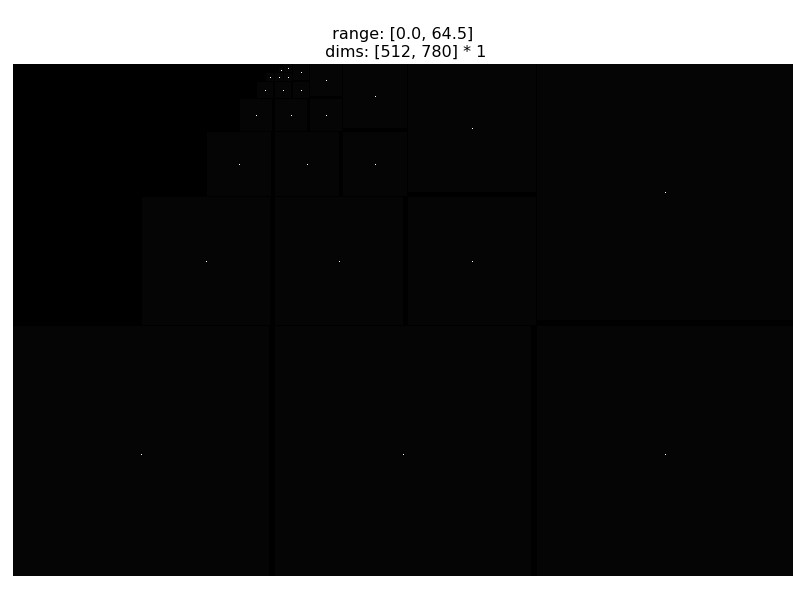

In [11]:
pyr.showPyr(prange='indep1')

In [12]:
# And take a look at the reconstruction of each band:
reconList = []
for lnum in range(int(pyr.height)):
    for bnum in range(pyr.numBands()):
        reconList.append(pyr.reconPyr([lnum], [bnum]))

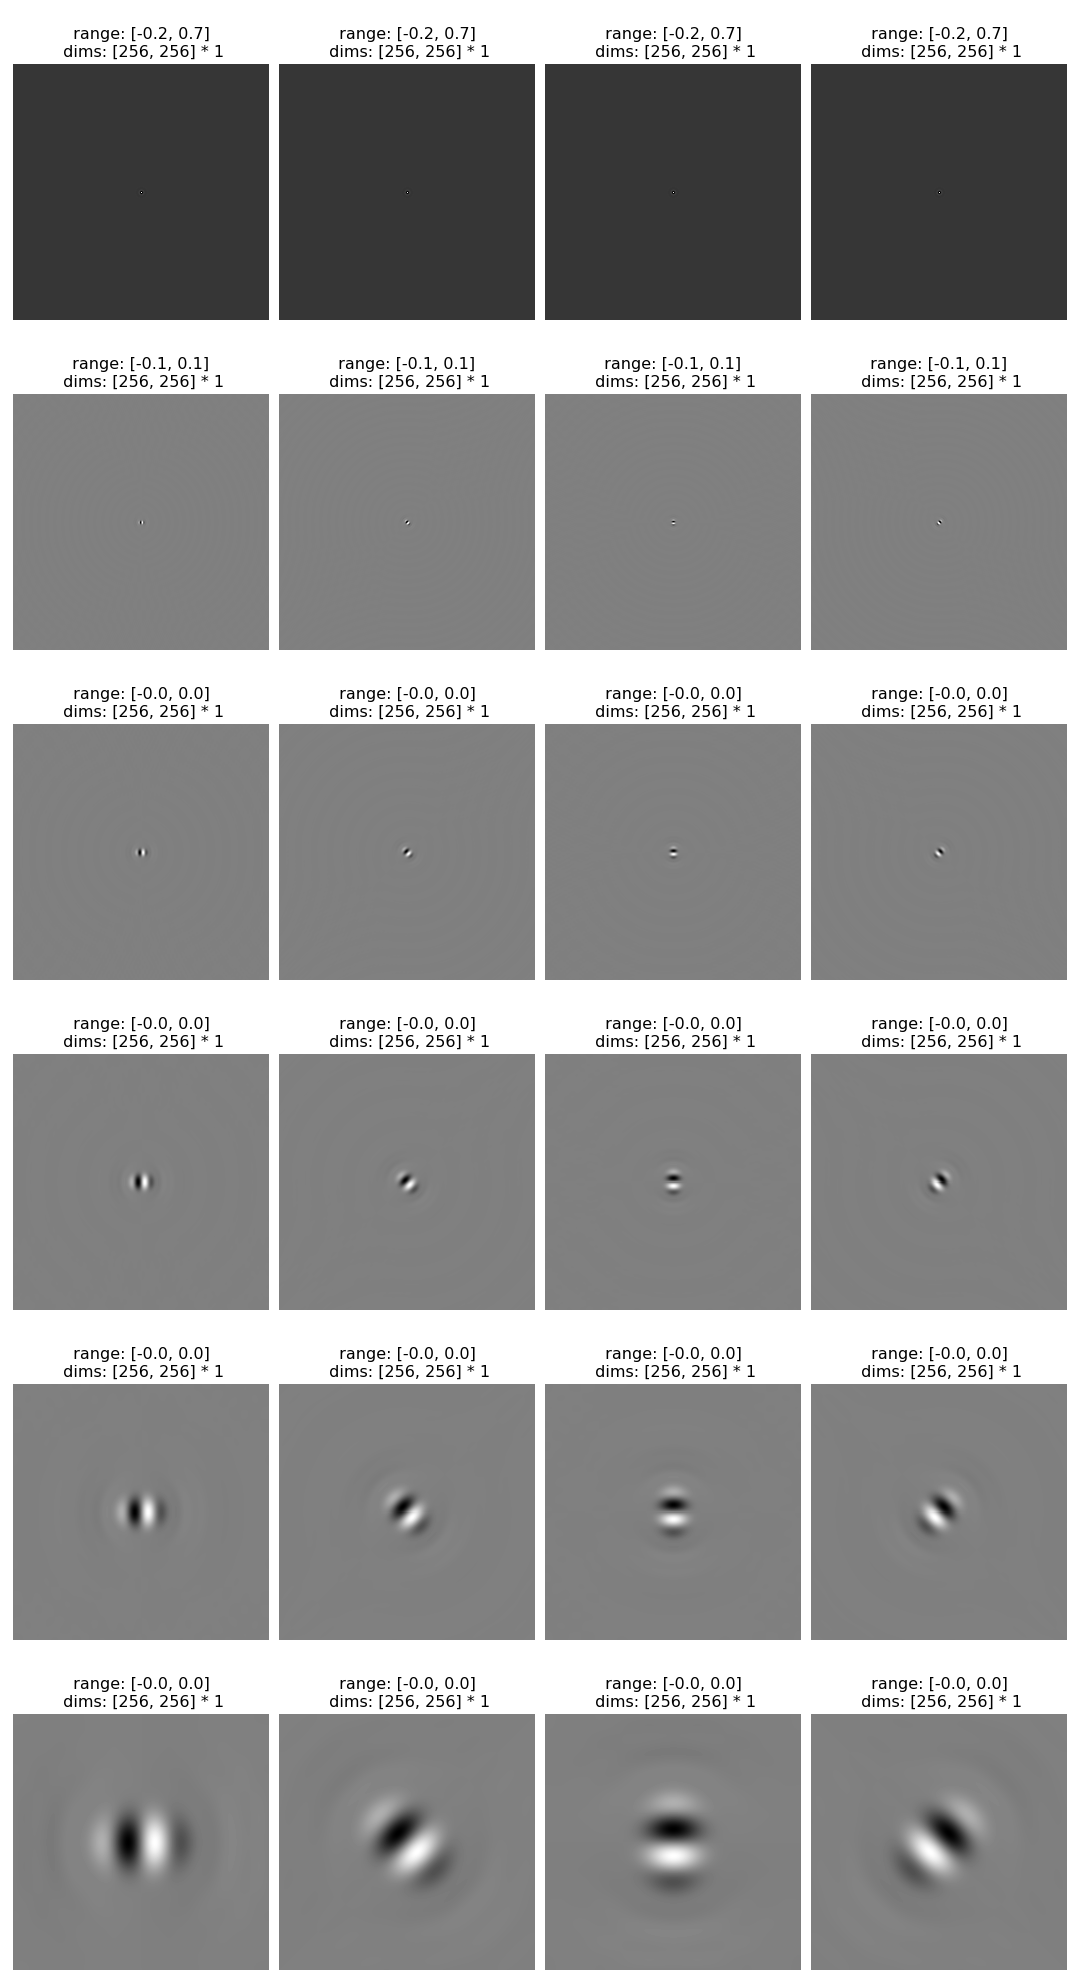

In [13]:
ppt.imshow(reconList, vrange='indep1', zoom=1, col_wrap=pyr.numBands());

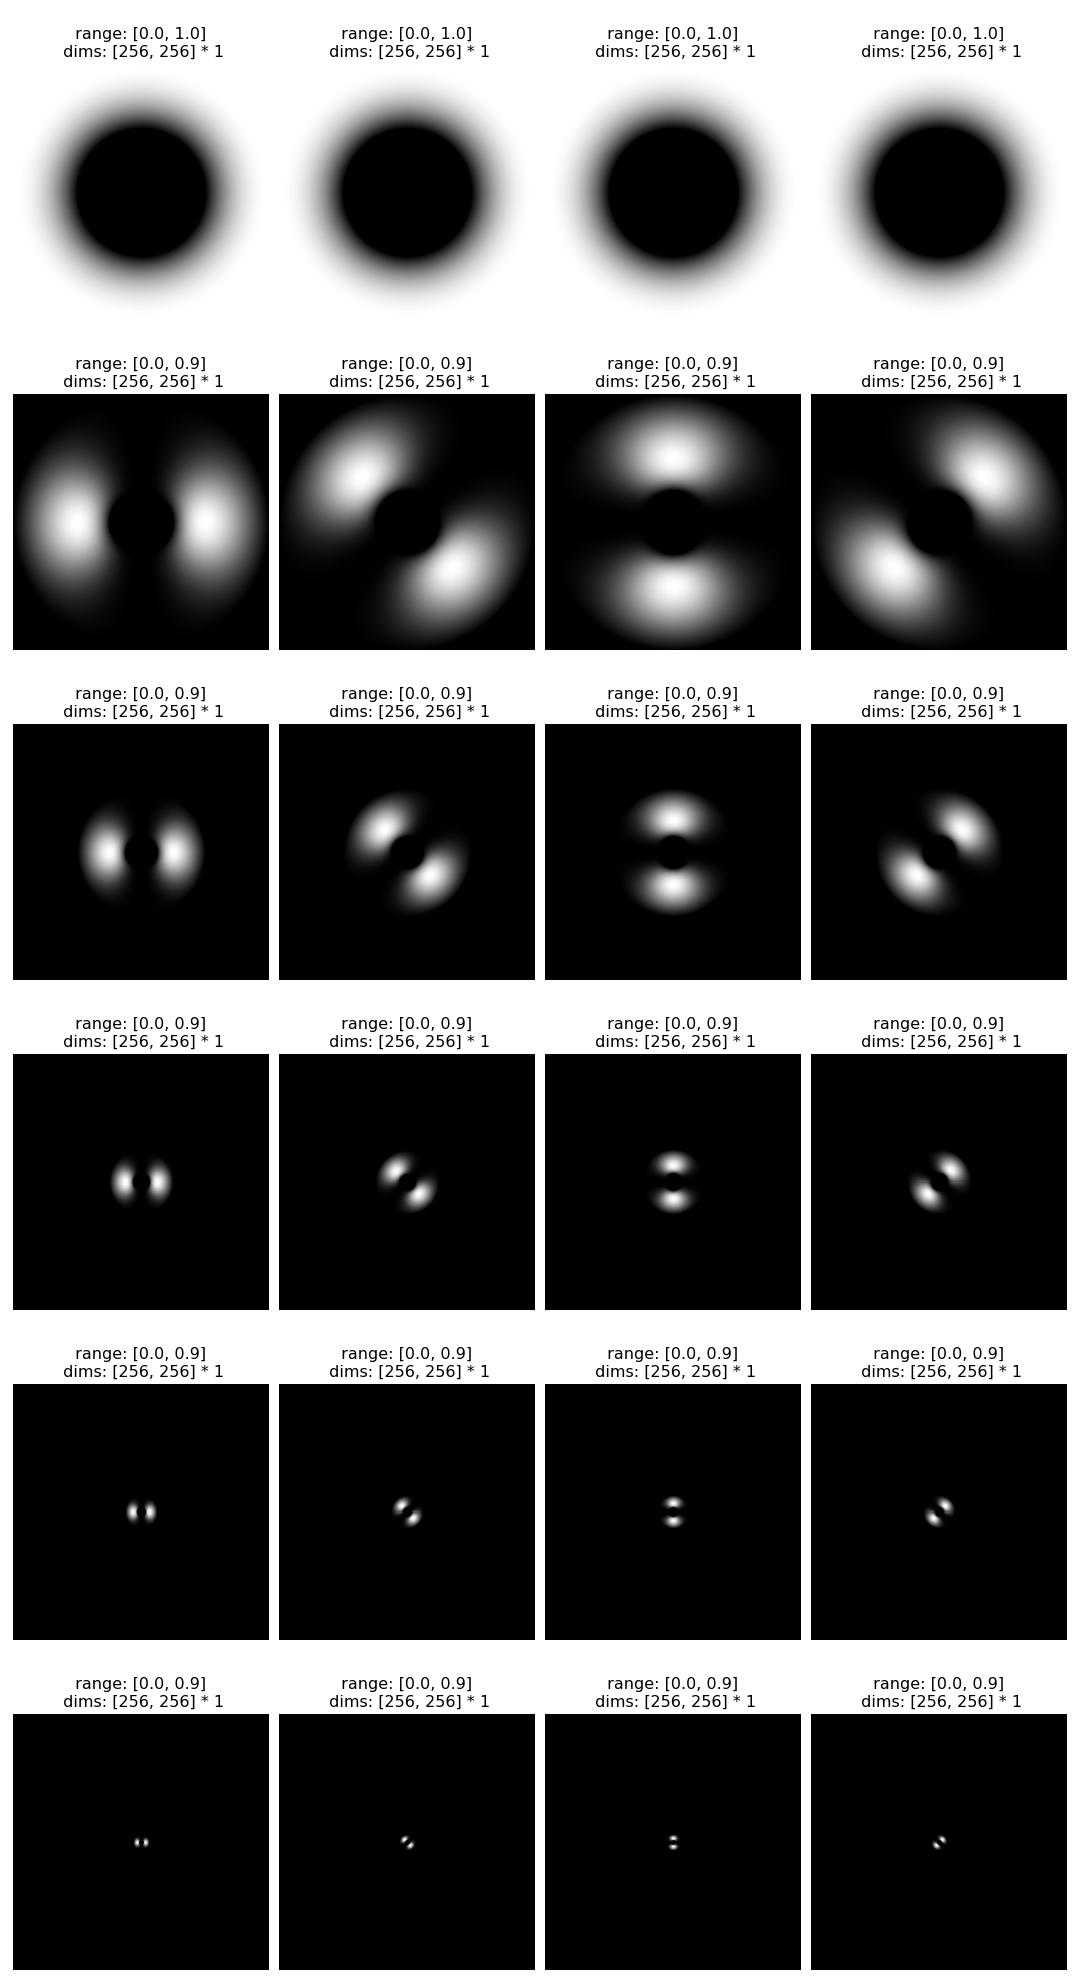

In [14]:
freq = 2 * np.pi * np.array(range(-sz//2,(sz//2)))/sz
imgList = []
for lnum in range(pyr.height):
    for bnum in range(pyr.numBands()):
        basisFn = pyr.reconPyr([lnum], [bnum])
        basisFmag = np.fft.fftshift(np.abs(np.fft.fft2(basisFn, (sz,sz))))
        imgList.append(basisFmag)

ppt.imshow(imgList, vrange='indep1', zoom=1, col_wrap=pyr.numBands());

In [15]:
# Steering the activations of a pyramid

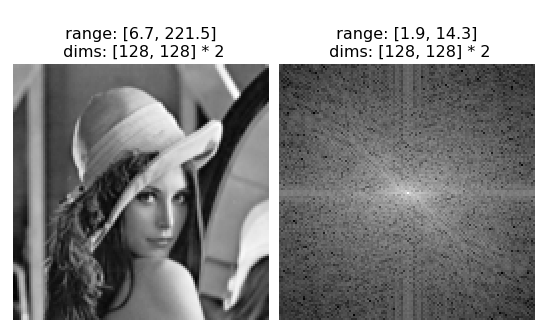

In [27]:
im = plt.imread('../DATA/lenna-256x256.tif').astype(float)

binom5 = ppt.binomialFilter(5)
lo_filt = binom5*binom5.T
im = ppt.corrDn(im, np.flipud(np.fliplr(lo_filt)), 'reflect1', step=[2, 2])

imgSize = im.shape[0]

sp = np.fft.fftshift(np.fft.fft2(im))
logfourieramplitude = np.log(np.abs(sp))
ppt.imshow([im, logfourieramplitude], vrange='indep1', zoom=2);

In [17]:
nOri = 3
pyr = ppt.SFpyr(im, height=1, order=nOri - 1)

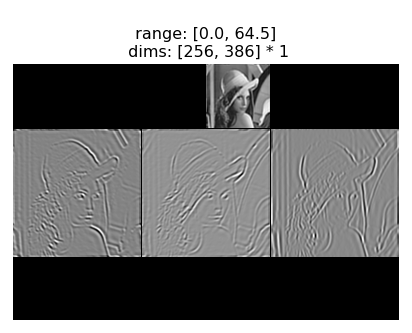

In [18]:
pyr.showPyr('indep1')

In [19]:
nOri = 5
even_phase = False

pyr = ppt.SFpyr(im, height=1, order=nOri - 1)

b = [pyr.pyr[i] for i in range(1, nOri + 1)]
B = np.vstack([b[i].flatten() for i in range(nOri)]).T

nSteeredOri = 100

steering_vectors = []
steered_activations = []
for i in np.linspace(-180, 180, nSteeredOri):
    bi, vi = ppt.steer(B, angle = i * np.pi / 180, return_weights=True, even_phase=even_phase)
    steering_vectors.append(vi)
    bi = bi.reshape((imgSize,imgSize))
    steered_activations.append(bi)

steering_vectors = np.array(steering_vectors).T
steered_activations = np.stack(steered_activations, axis=-1)

In [20]:
ppt.animshow(steered_activations)

In [21]:
# in the frequency domain

In [22]:
steeredim_dftampl = np.zeros_like(steered_activations)
for i in range(steered_activations.shape[-1]):
    steeredim_dftampl[:,:,i] = np.fft.fftshift(np.abs(np.fft.fft2((steered_activations[:,:,i]),s=(imgSize, imgSize))))

In [23]:
ppt.animshow(steeredim_dftampl)

In [24]:
# the steering weighting vectors

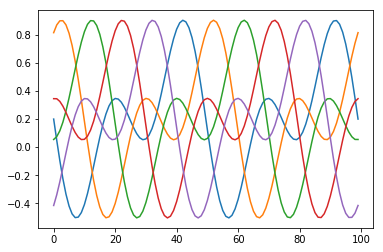

In [25]:
plt.figure()
for i in range(nOri):
    plt.plot(steering_vectors[i,:])
plt.show()

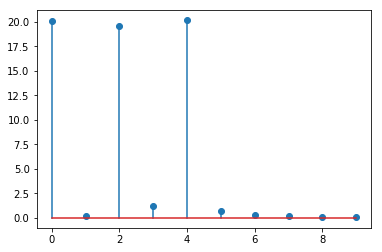

In [26]:
# expected harmonics (up to sapling error)
i = np.random.choice(nOri)
sp = np.fft.fftshift(np.fft.fft(steering_vectors[i,:]))
plt.stem(np.abs(sp)[sp.shape[0] // 2 : sp.shape[0] // 2 + nOri * 2])
plt.show()